# Spotify podcast dataset: genre reduction and transcript embeddings IF-IDF
Yuchen Luo

2022-11-02
_________

Steps: 

- Make a new metadata table for each individual podcast episode
- Tf-IDF 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import re
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
# !pip install torch
# !pip install pytorch_transformers
# !pip install sentence_transformers

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## New metadata

We're going to keep just the large-scale categories, and if there's more than one of them we'll use just the first one listed. Then, let's examine how many podcasts (and how many transcripts per podcast) we have within each category.

In [ ]:
os.path.dirname(os.path.realpath("show_categories.tsv"))

'/content'

In [ ]:
metadata_raw = pd.read_csv('drive/My Drive/Colab Notebooks/show_categories.tsv', sep='\t')
raw_categories = metadata_raw.columns[3:]
print(list(raw_categories))

['After_Shows', 'Alternative_Health', 'Amateur', 'Animation_and_Manga', 'Arts', 'Automotive', 'Aviation', 'Baseball', 'Basketball', 'Books', 'Buddhism', 'Business', 'Business_News', 'Careers', 'Chemistry', 'Christianity', 'College_and_High_School', 'Comedy', 'Comedy_Fiction', 'Comedy_Interviews', 'Courses', 'Crafts', 'Cricket', 'Daily_News', 'Design', 'Documentary', 'Drama', 'Earth_Sciences', 'Education', 'Education_for_Kids', 'Entertainment_News', 'Entrepreneurship', 'Fantasy_Sports', 'Fashion_and_Beauty', 'Fiction', 'Film_History', 'Film_Interviews', 'Film_Reviews', 'Fitness', 'Food', 'Football', 'Games', 'Games_and_Hobbies', 'Golf', 'Government', 'Health', 'Health_and_Fitness', 'Hinduism', 'History', 'Hobbies', 'Hockey', 'Home_and_Garden', 'How_To', 'Improv', 'Investing', 'Islam', 'Judaism', 'Kids_and_Family', 'Language_Learning', 'Leisure', 'Life_Sciences', 'Literature', 'Management', 'Marketing', 'Mathematics', 'Medicine', 'Mental_Health', 'Music', 'Music_Commentary', 'Music_Histo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
super_to_sub = {'arts':['Arts','Books','Design','Fashion_and_Beauty','Food','Performing_Arts','Visual_Arts'],
                'business':['Business','Careers','Entrepreneurship','Investing','Management','Marketing','Non-Profit'],
                'comedy':['Comedy', 'Comedy_Interviews','Improv','Stand-Up'],
                'education':['Education', 'Courses','How_To','Language_Learning','Self-Improvement'],
                'fiction':['Fiction', 'Comedy_Fiction', 'Drama', 'Science_Fiction'],
                'government':['Government'],
                'health_and_fitness':['Health_and_Fitness','Alternative_Health','Fitness','Medicine','Mental_Health','Nutrition','Sexuality'],
                'history':['History'], 
                'kids_and_family':['Kids_and_Family','Education_for_Kids','Parenting','Pets_and_Animals','Stories_for_Kids'],
                'leisure':['Leisure','Animation_and_Manga','Automotive','Aviation','Crafts','Games','Hobbies','Home_and_Garden','Video_Games'],
                'music':['Music','Music_Commentary','Music_History','Music_Interviews'],
                'news':['News','Business_News','Daily_News','Entertainment_News','News_Commentary','Politics','Sports_News','Tech_News'],
                'religion_and_spirituality':['Religion_and_Spirituality','Buddhism','Christianity','Hinduism','Islam','Judaism','Religion','Spirituality'],
                'science':['Science','Astronomy','Chemistry','Earth_Sciences','Life_Sciences','Mathematics',
                           'Natural_Sciences','Nature','Physics','Social_Sciences'],
                'society_and_culture':['Society_and_Culture','Documentary','Personal_Journals','Philosophy','Places_and_Travel','Relationships'],
                'sports':['Sports','Baseball','Basketball','Cricket','Fantasy_Sports','Football','Golf','Hockey','Rugby','Running',
                          'Soccer','Swimming','Tennis','Volleyball','Wilderness','Wrestling'],
                'tv_and_film':['TV_and_Film','After_Shows','Film_History','Film_Interviews','Film_Reviews','TV_Reviews'],
                'technology':['Technology'],
                'true_crime':['True_Crime']
               }

In [ ]:
sub_to_super = {subcategory:supercategory for supercategory in super_to_sub for subcategory in super_to_sub[supercategory]}
len(sub_to_super), [x for x in raw_categories if x not in sub_to_super]

(110,
 ['Amateur',
  'College_and_High_School',
  'Games_and_Hobbies',
  'Health',
  'Literature',
  'Outdoor',
  'Podcasting',
  'Self-Help',
  'Sports_and_Recreation'])

Some subcategories are missing; let's put them in appropriate supercategories.

In [ ]:
sub_to_super['Amateur'] = 'society_and_culture'
sub_to_super['College_and_High_School'] = 'education'
sub_to_super['Games_and_Hobbies'] = 'leisure'
sub_to_super['Health'] = 'health_and_fitness'
sub_to_super['Literature'] = 'arts'
sub_to_super['Outdoor'] = 'leisure'
sub_to_super['Podcasting'] = 'society_and_culture'
sub_to_super['Self-Help'] = 'health_and_fitness'
sub_to_super['Sports_and_Recreation'] = 'sports'

Now, let's go back to the metadata file and tag the shows with the supercategories.

In [ ]:
show_metadata_df = pd.DataFrame()
show_metadata_df['show'] = metadata_raw['show']

def process_categories(categories):
    if categories == 'set()':
        return ''
    category_list = [x.strip()[1:-1] for x in categories[1:-1].split(',')]
    category_list = [x.replace(' ','_').replace('&','and') for x in category_list]
    return sub_to_super[category_list[0]]

show_metadata_df['category'] = metadata_raw['categories'].apply(process_categories)
show_metadata_df = show_metadata_df.set_index('show')

In [ ]:
show_metadata_df

,category
show,
show_2NYtxEZyYelR6RMKmjfPLB,leisure
show_15iWCbU7QoO23EndPEO6aN,true_crime
show_0g0gZz74AKcS1MpJJ1T01N,government
show_1dyTrS3vDtpClrURfKdo3q,education
show_162GxLtTwesdY2cVUM4x0H,education
...,...
show_1f0Kj9MZnk8zet8xtsyNDR,science
show_1UqLURSc1vBfAk4ZkiPeXQ,society_and_culture
show_2udB9U1T4YKLbEVPPN0EEj,comedy


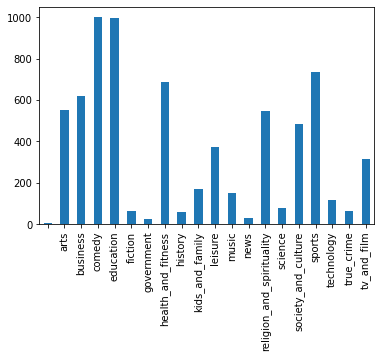

In [ ]:
show_metadata_df['category'].value_counts().sort_index().plot.bar()

OK, the classes are definitely not balanced, but let's see the number of actual episodes in each podcast before rejecting anything.

### Load up the episode information only

In [ ]:
all_episodes_metadata_df = pd.DataFrame()
for transcript_file in tqdm(sorted(os.listdir('drive/MyDrive/transcript_tables/'))):
    all_episodes_metadata_df = pd.concat([all_episodes_metadata_df, pd.read_csv(f'drive/MyDrive/transcript_tables/{transcript_file}', sep='\t', usecols=['show','episode'])])

all_episodes_metadata_df.reset_index(inplace=True,drop=True)

100%|██████████| 108/108 [00:34<00:00,  3.09it/s]


In [ ]:
all_episodes_metadata_df['category'] = all_episodes_metadata_df['show'].apply(lambda x: show_metadata_df.loc[x].category)

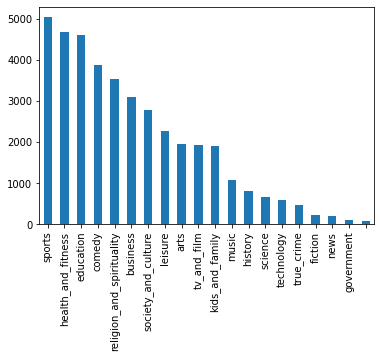

sports                       5038
health_and_fitness           4668
education                    4617
comedy                       3877
religion_and_spirituality    3526
business                     3106
society_and_culture          2779
leisure                      2270
arts                         1949
tv_and_film                  1928
kids_and_family              1914
music                        1087
history                       818
science                       655
technology                    600
true_crime                    468
fiction                       222
news                          203
government                     95
                               72
Name: category, dtype: int64


In [ ]:
all_episodes_metadata_df.category.value_counts().plot.bar()
plt.show()
print(all_episodes_metadata_df.category.value_counts())

For now, let's not consider the categories with fewer than 500 episodes. 

### Load up the transcripts 

In [ ]:
all_episodes_transcripts_df = pd.DataFrame()
for transcript_file in tqdm(sorted(os.listdir('drive/MyDrive/transcript_tables/'))):
    all_episodes_transcripts_df = pd.concat([all_episodes_transcripts_df, pd.read_csv(f'drive/MyDrive/transcript_tables/{transcript_file}', sep='\t')])

all_episodes_transcripts_df.reset_index(inplace=True)
all_episodes_transcripts_df.drop(columns=['index','Unnamed: 0'], inplace=True)

100%|██████████| 108/108 [00:19<00:00,  5.51it/s]


In [ ]:
all_episodes_transcripts_df.head()

,show,episode,transcript
0,show_00iaP2GhJUWHAovx41BN5N,2VVBXyGRGd2cydXPxHJme6,Welcome back to GRE vocab. Before we continue....
1,show_00iaP2GhJUWHAovx41BN5N,3jIQUvPSaCcMOpJfx5AB1w,Welcome back to another episode of a GRE vocab...
2,show_00iaP2GhJUWHAovx41BN5N,3iRJkm19fnZkdwW7nTX5Yb,Welcome back to the GRE vocab podcast. We use ...
3,show_00iaP2GhJUWHAovx41BN5N,3vdykhEg3lYhfXEVIIB8GH,Welcome back to episode 5 of GRE vocab today t...
4,show_00iaP2GhJUWHAovx41BN5N,4Xsex7XPthez6srVIdv4vU,Welcome back to GRE vocab today are five words...


### Preprossessing

> Indented block



In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
      
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
lst_stopwords = nltk.corpus.stopwords.words("english")

In [ ]:
all_episodes_transcripts_df['clean_transcript'] = all_episodes_transcripts_df['transcript'].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

all_episodes_transcripts_df.head()

,show,episode,transcript,clean_transcript
0,show_00iaP2GhJUWHAovx41BN5N,2VVBXyGRGd2cydXPxHJme6,Welcome back to GRE vocab. Before we continue....,welcome back gre vocab continue want give quic...
1,show_00iaP2GhJUWHAovx41BN5N,3jIQUvPSaCcMOpJfx5AB1w,Welcome back to another episode of a GRE vocab...,welcome back another episode gre vocab two par...
2,show_00iaP2GhJUWHAovx41BN5N,3iRJkm19fnZkdwW7nTX5Yb,Welcome back to the GRE vocab podcast. We use ...,welcome back gre vocab podcast use gre vocab w...
3,show_00iaP2GhJUWHAovx41BN5N,3vdykhEg3lYhfXEVIIB8GH,Welcome back to episode 5 of GRE vocab today t...,welcome back episode 5 gre vocab today next fi...
4,show_00iaP2GhJUWHAovx41BN5N,4Xsex7XPthez6srVIdv4vU,Welcome back to GRE vocab today are five words...,welcome back gre vocab today five word prodiga...


In [ ]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=1000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=1000, ngram_range=(1,2))

In [ ]:
corpus = all_episodes_transcripts_df['clean_transcript']
vectorizer.fit(corpus)
embeddings = vectorizer.transform(corpus)

### Make the embeddings for all the transcripts

The sentence averaging took a super long time, so I encoded the entirety of the transcript instead.

In [ ]:
episode_ids = []
transcript_embeddings = []
for i in range(len(all_episodes_transcripts_df)):
    if (i+1) % 50 == 0:
        print(f'finished {i+1} transcripts')
    episode_ids.append(all_episodes_metadata_df['episode'].iloc[i])
    transcript = all_episodes_transcripts_df['transcript'].iloc[i]
    transcript_embeddings.append(embeddings[i].toarray())

In [ ]:
transcript_embeddings_array = np.asarray(transcript_embeddings).tolist()

In [ ]:
tfidf_df = pd.DataFrame(pd.DataFrame(x[0] for x in transcript_embeddings_array))
tfidf_df['episode_id'] = episode_ids
tfidf_df['show_id'] = all_episodes_metadata_df['show']
tfidf_df['category'] = all_episodes_metadata_df['category']
tfidf_df = tdidf_df[list(tfidf_df.columns[-3:]) + list(tfidf_df.columns[:-3])]
# tdidf_df[3:1003] = tdidf_df['0'].str.split('\t')

In [ ]:
tfidf_df

,episode_id,show_id,category,0,1,2,3,4,5,6,...,990,991,992,993,994,995,996,997,998,999
0,2VVBXyGRGd2cydXPxHJme6,show_00iaP2GhJUWHAovx41BN5N,education,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.057822,0.00000,0.0,0.0,0.000000,0.000000
1,3jIQUvPSaCcMOpJfx5AB1w,show_00iaP2GhJUWHAovx41BN5N,education,0.000000,0.0,0.076390,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
2,3iRJkm19fnZkdwW7nTX5Yb,show_00iaP2GhJUWHAovx41BN5N,education,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
3,3vdykhEg3lYhfXEVIIB8GH,show_00iaP2GhJUWHAovx41BN5N,education,0.056107,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.115447,0.00000,0.0,0.0,0.000000,0.000000
4,4Xsex7XPthez6srVIdv4vU,show_00iaP2GhJUWHAovx41BN5N,education,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.092139,...,0.0,0.000000,0.000000,0.000000,0.046252,0.00000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39887,6p4wARRoyULG9S2IQFRMYe,show_2zwCSqNh7sb7iMXG7WAus9,government,0.012041,0.0,0.000000,0.00000,0.014587,0.0,0.000000,...,0.0,0.000000,0.018235,0.006954,0.024775,0.00000,0.0,0.0,0.016303,0.008619
39888,3QRHueGLTkqwyR28gC4yUq,show_2zwCSqNh7sb7iMXG7WAus9,government,0.006610,0.0,0.008354,0.00718,0.008009,0.0,0.009032,...,0.0,0.008987,0.013349,0.022907,0.022669,0.00638,0.0,0.0,0.023869,0.000000
39889,2kJkGRhcGZDEumoMllxLTT,show_2Z3X5kJDGyjKwkXtq16kzR,arts,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000
39890,3AHQCGfshsjCYxzrNj7YDL,show_2zpvSmm7aTdwICTtzdw6oQ,education,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000


In [ ]:
# tfidf_df = pd.read_csv("transcript_embeddings_tfidf.csv")
sim = cosine_similarity(tfidf_df.iloc[0:10, 4:])
sim_df = pd.DataFrame(sim)
sim_df.columns = tfidf_df['episode_id'][0:10]
sim_df.index = tfidf_df['episode_id'][0:10]

In [ ]:
sim_df

episode_id,2VVBXyGRGd2cydXPxHJme6,3jIQUvPSaCcMOpJfx5AB1w,3iRJkm19fnZkdwW7nTX5Yb,3vdykhEg3lYhfXEVIIB8GH,4Xsex7XPthez6srVIdv4vU,6Fb2z1SKheY5vsu0JvuJ8g,30mBnCfq6iv4oAVvUbb9hV,0dC1ZPQQYjwAiyF2wLph9v,6O1QavzUyh62xCzAgz51Rg,4ntIONUHDoL5DAsIMvuztW
episode_id,,,,,,,,,,
2VVBXyGRGd2cydXPxHJme6,1.000000,0.547937,0.587748,0.585409,0.555350,0.583497,0.545794,0.477678,0.328146,0.555269
3jIQUvPSaCcMOpJfx5AB1w,0.547937,1.000000,0.488538,0.494623,0.509256,0.553476,0.500163,0.527040,0.437542,0.508697
3iRJkm19fnZkdwW7nTX5Yb,0.587748,0.488538,1.000000,0.425191,0.477401,0.508417,0.470442,0.377013,0.274884,0.477037
3vdykhEg3lYhfXEVIIB8GH,0.585409,0.494623,0.425191,1.000000,0.507425,0.483678,0.588879,0.519586,0.393545,0.494856
4Xsex7XPthez6srVIdv4vU,0.555350,0.509256,0.477401,0.507425,1.000000,0.497503,0.519326,0.437724,0.346323,0.470695
6Fb2z1SKheY5vsu0JvuJ8g,0.583497,0.553476,0.508417,0.483678,0.497503,1.000000,0.496403,0.440347,0.410607,0.567683
30mBnCfq6iv4oAVvUbb9hV,0.545794,0.500163,0.470442,0.588879,0.519326,0.496403,1.000000,0.451667,0.360041,0.456828
0dC1ZPQQYjwAiyF2wLph9v,0.477678,0.527040,0.377013,0.519586,0.437724,0.440347,0.451667,1.000000,0.443564,0.422192
6O1QavzUyh62xCzAgz51Rg,0.328146,0.437542,0.274884,0.393545,0.346323,0.410607,0.360041,0.443564,1.000000,0.390645


Columns to have for final export:
- episode_id
- show_id
- category (reduced down from itunes)
- embedding columns

In [ ]:
tfidf_df.to_csv('transcript_embeddings_tfidf.csv')